# Importing library

In [61]:
# feature extracting and data preprocessing
import librosa
import librosa.display
from pathlib import Path
import os
import matplotlib.pyplot as plt
%matplotlib inline
import csv
import numpy as np
import pandas as pd

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers

import warnings
warnings.filterwarnings('ignore')

# Data Extraction

Spectrogram

In [ ]:
# data extracting -- converting .wav to .png
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
for g in genres:
    Path(f'./data_img/{g}').mkdir(parents=True, exist_ok=True)                  # creating new directory for data 
    for filename in os.listdir(f'./genres/{g}'):
        if filename.endswith('.wav'):                                           # determine if the file is .wav file 
            song = f'./genres/{g}/{filename}'                                   # obtaining audio file's path
            x, sr = librosa.load(song, mono = True, duration=5)                    # loading audio(5s, original sr is 22050)
            X = librosa.stft(x)                                                     # standarization
            Xdb = librosa.amplitude_to_db(abs(X))
            spec=librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')  # getting spectrogram
            plt.axis('off')                                                         # delete axis from the figure
            plt.savefig(f'./data_img/{g}/{filename[:-4]}.png')                      # save image as data
            plt.clf()                                                               # don't display   

Features:

* Mel-frequency cepstral coefficients (MFCC)(100 in number)
* Spectral Centroid,
* Zero Crossing Rate
* Chroma Frequencies
* Spectral Roll-off.

In [2]:
header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth spectral_rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'    # 20 mfccs
header += ' label'
header = header.split()

In [3]:
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()

file = open('data.csv', 'w')        # 'w'--create(if not exist), open and write from start
with file:
    writer = csv.writer(file)
    writer.writerow(header)
for g in genres:
    for filename in os.listdir(f'./genres/{g}'):
        if filename.endswith('.wav'):
            song = f'./genres/{g}/{filename}'                               
            x, sr = librosa.load(song, duration=10)           # use the first 10s
            chroma_stft = librosa.feature.chroma_stft(x, sr)
            rmse = librosa.feature.rms(x)
            spec_cent = librosa.feature.spectral_centroid(x, sr)
            spec_bw = librosa.feature.spectral_bandwidth(x, sr)
            rolloff = librosa.feature.spectral_rolloff(x, sr)
            zcr = librosa.feature.zero_crossing_rate(x, sr)
            mfcc = librosa.feature.mfcc(x, sr)
            to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'
            for e in mfcc:
                to_append += f' {np.mean(e)}'          # 20 mfccs
            to_append += f' {g}'                       # label
            file = open('data.csv', 'a')               # 'a'--add(in a new row)
            with file:
                writer = csv.writer(file)
                writer.writerow(to_append.split())

# Ploting Function
Reference: https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

In [4]:
# Draw learning curves for training and validation

def plot_learning_curve(history):
    
    # list all data in history
    keys = history.history.keys()
    print(keys)
    
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    if 'val_accuracy' in keys:
        plt.plot(history.history['val_accuracy'])
        plt.legend(['train', 'val'], loc='upper left')
    else:
        plt.legend(['train'], loc='upper left')
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    if 'val_accuracy' in keys:
        plt.plot(history.history['val_loss'])
        plt.legend(['train', 'val'], loc='upper left')
    else:
        plt.legend(['train'], loc='upper left')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

# Preprocess

In [4]:
data = pd.read_csv('data.csv')

genre_list = data.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)

scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, 1:-1], dtype=float))

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# print('Number of samples: ' + str(X.shape[0]))
# print('Number of training samples: ' + str(X_train.shape[0]))
# print('Number of testing samples: ' + str(X_test.shape[0]))

## PCA

Text(0.5, 1.0, 'Sree Plot')

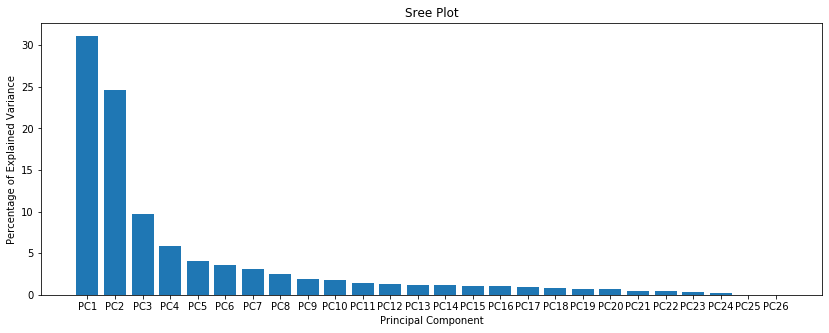

In [5]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

pca = PCA()
pca.fit(X)
pca_data = pca.transform(X)

per_var = np.round(pca.explained_variance_ratio_*100, 1)  # keep 1 decimals
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

plt.figure(figsize=(14,5))
plt.bar(x=range(1, len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Sree Plot')

Using the first 1 PC

In [47]:
X_pca = pca_data[:, 0:1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print('Number of samples: ' + str(X.shape[0]))
print('Number of training samples: ' + str(X_train.shape[0]))
print('Number of testing samples: ' + str(X_test.shape[0]))

Number of samples: 834
Number of training samples: 667
Number of testing samples: 167


# Training with different models

In [42]:
model_name = ['NeuralNetwork', 'LogisticRegression', 'SVM', 'LibSVM',
              'DecisionTree', 'Adaboost', 'RandomForest', 'KNN', 'KNN_dis']
acc = []

## 1. Neural Network

In [48]:
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy', 
             metrics=['accuracy'])

model.summary()


history = model.fit(X_train, 
                   y_train, 
                   epochs=100,
                   batch_size=32,
                   validation_data=(X_test, y_test),
                   verbose=0)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 256)               6912      
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 10)                2570      
Total params: 75,274
Trainable params: 75,274
Non-trainable params: 0
_________________________________________________________________


dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


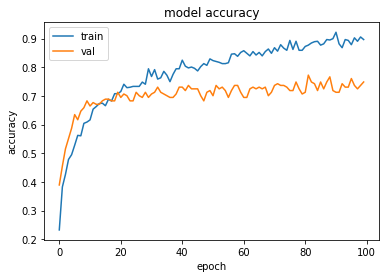

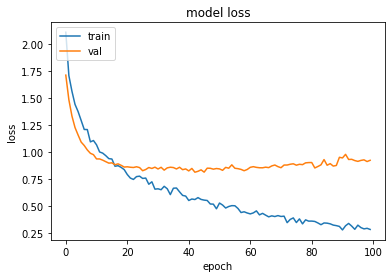

In [38]:
plot_learning_curve(history)

In [49]:
model.evaluate(X_test, y_test)

167/167 [==============================] - 0s 114us/step


[0.9303083223497083, 0.7485029697418213]

In [50]:
lo, ac = model.evaluate(X_test, y_test)

acc.append(ac)

167/167 [==============================] - 0s 111us/step


## 2. LogisticRegression

In [51]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

model.fit(X_train, y_train)

acc.append(model.score(X_test, y_test))

model.score(X_test, y_test)

0.718562874251497

## 3. SVM

In [52]:
from sklearn.svm import SVC

model = SVC()

model.fit(X_train, y_train)

acc.append(model.score(X_test, y_test))

model.score(X_test, y_test)

0.6766467065868264

## 3b. SVM

In [53]:
model = SVC(probability=False,  kernel="linear", C=2.8, gamma=.0073,verbose=10)

model.fit(X_train, y_train)

acc.append(model.score(X_test, y_test))

model.score(X_test, y_test)

[LibSVM]

0.6826347305389222

## 4. Decision Tree

In [54]:
from sklearn.tree import DecisionTreeClassifier as DT

tree = DT()

tree.fit(X_train, y_train)

acc.append(tree.score(X_test, y_test))

model.score(X_test, y_test)

0.6826347305389222

## 5. AdaBoost

In [55]:
from sklearn.ensemble import AdaBoostClassifier

model = AdaBoostClassifier(base_estimator=tree)

model.fit(X_train, y_train)

acc.append(model.score(X_test, y_test))

model.score(X_test, y_test)

0.5389221556886228

## 6. RandomForest

In [56]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()

model.fit(X_train, y_train)

acc.append(model.score(X_test, y_test))

model.score(X_test, y_test)

0.6107784431137725

## 7a. KNN

In [57]:
from sklearn.neighbors import KNeighborsClassifier as KNN

model = KNN()

model.fit(X_train, y_train)

acc.append(model.score(X_test, y_test))

model.score(X_test, y_test)

0.6107784431137725

## 7b. KNN

In [58]:
model = KNN(weights='distance')

model.fit(X_train, y_train)

acc.append(model.score(X_test, y_test))

model.score(X_test, y_test)

0.6347305389221557

# Results

In [59]:
df = pd.DataFrame({'Model': model_name,'Accuracy': acc})
df.sort_values(by='Accuracy', ascending=False)

,Model,Accuracy
0,NeuralNetwork,0.748503
1,LogisticRegression,0.718563
3,LibSVM,0.682635
2,SVM,0.676647
8,KNN_dis,0.634731
6,RandomForest,0.610778
7,KNN,0.610778
4,DecisionTree,0.550898
5,Adaboost,0.538922
